# Loading Data and Performing Stylometric Analysis

## What is Stylometry?

[EXPLAIN WHAT STYLOMETRY IS]

Import necessary libraries

In [1]:
# Tokenization / data processing
import pandas as pd
import nltk
import string
import contractions
from collections import defaultdict
from profanity import profanity
from typing import Any, TypeVar
T = TypeVar("T")

# Plotting data
import matplotlib.pyplot as plt
import numpy as np

# Data analysis
from scipy.stats import pearsonr

# File processing
import os

Declaration of universal constants

In [2]:
# List of Taylor Swift albums
ALBUMS = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", 
          "Red (Taylor's Version)", "1989 (Taylor's Version)", "reputation", "Lover", 
          "folklore", "evermore", "Midnights", "The Tortured Poets Department"]

# corresponding album shortenings -- used in data visualization for simplicity
SHORTENINGS = ["Debut", "Fearless", "Speak Now", 
          "Red", "1989", "Rep", "Lover", 
          "Folklore", "Evermore", "Midnights", "TTPD"]

# color used in graphs
COLOR = ['#008080', '#D7B575', '#774F8F', '#921D16', '#5585AC', '#202020', '#df6cab', '#05472A', '#B05925', '#4B5A86', '#BDAE95']

In [3]:
def initial_data_preparation(df : pd.DataFrame, 
                             music_stop_words : list[str]) -> T:
    '''
    Description
    -----------
    Creates dictionaries to store the relevant count data, and iterates through the data frame to read in lyrics
    Returns the df, as well as a bunch of dictionaries

    Parameters
    ----------
    df : pd.DataFrame
        A Pandas dataframe that stores album, song, and lyric data
    music_stop_words: list[str]
        A list of non-contentful words unwanted for music analysis
    
    '''

    # Lists of relevant pronoun words
    first_person_singular = ["i", "me", "my", "mine", "myself"]
    first_person_plural = ["us", "we", "our", "ours", "ourselves"]
    second_person = ["you", "your", "yours", "yourself", "yourselves"]

    # Dictionary that holds a list of every word in a song, per album
    total_words_per_song = defaultdict(lambda : defaultdict(list[str]))

    # Dictionary that holds a set of every unique word in a song, per album
    unique_words_per_song = defaultdict(lambda : defaultdict(set[str]))

    # Dictionary that holds word length per song, per album
    word_length_per_song = defaultdict(lambda : defaultdict(int))

    # Dictionary that holds counts of first person singular, first person plurl, and second person pronouns
    pronoun_use_per_song = defaultdict(lambda : defaultdict( lambda : defaultdict(int)))

    # Dictionary that holds profanity percentages for each album
    profanity_per_album = defaultdict(int)

    # Dictionary that holds the number of songs per album
    num_songs = defaultdict(int)


    # Boolean value that keeps track of whether the lyric is part of a chorus/verse marker
    # These markers are in the lyrics as [CHORUS]; [VERSE], for example
    within_description = False

    # Iterates over lyrics in the dataframe
    for lyric in df['Lyrics']:

        # Saves the song title
        song_title = df.loc[df['Lyrics'] == lyric, 'Title']
        song_title = song_title.iloc[0]

        # Saves the album name
        album_name = df.loc[df['Lyrics'] == lyric, 'Album']
        album_name = album_name.iloc[0]
        
        # Updates the number of songs in an album
        num_songs[album_name] += 1

        # Saves each lyric as a list
        word_list=lyric.split()

        # String that will store the cleaned lyrics
        word_data = ""

        for word in word_list:

            # Handles chorus and verse markers and excluding them from tokenized data
            if "[" or "]" in word:
                if "[" in word and not("]" in word):
                    within_description = True
                elif "]" in word and not("[" in word):
                    within_description = False
                elif "[" in word and "]" in word:
                    within_description = False
                if "(" in word and not(")" in word):
                    within_description = True
                elif ")" in word and not("(" in word):
                    within_description = False
                elif "(" in word and ")" in word:
                    within_description = True
            
            # Adds relevant lyric data to word_data
            if not("]" in word or "[" in word or "(" in word or ")" in word) and not(within_description):
                for contraction in contractions.contractions_dict.keys():
                    
                    # Splits contractions into two words
                    if contraction.lower() in word.lower():
                        word = contractions.fix(word)

                word_data += word + " "

        # Tokenize lyrics
        nltk_tokens = nltk.word_tokenize(text=word_data, language='english', preserve_line=True)

        # List of corrected tokens
        new_tokens_list = []

        # Set of corrected tokens -- used for storing unique counts
        new_tokens_set = set()

        # Total number of (non-unique) characters in a song
        token_length = 0

        for token in nltk_tokens:
            
            # lowercases the token for efficiency in counting
            token = token.lower()

            # Corrects tokens, ensuring that words are correctly counted for what they mean
            if token not in music_stop_words and token not in string.punctuation:
                if token in {"i-i-i-i", "i-i", "i-i-i"}:
                    token = "i"
                if token in {"me-e-e", "me-e-e-e-e", "me-e-e-e-e-e"}:
                    token = "me"
                if token == "mind-ind-ind":
                    token = "mind"
                if token == "drowning-ing-ing-ing-ing":
                    token = "drowning"
                if token == "see-e-e-e-e-e":
                    token = "see"
                if token == "vendetta-ta":
                    token = "vendetta"
                if token == "i-island":
                    token = "island"
                if token == "trip-trippin":
                    token = "trippin"
                if token == "skip-skippin":
                    token = "skippin"
                if token == "d-y-i-n-g":
                    token = "dying"
                
                # Append tokens
                new_tokens_list.append(token)
                new_tokens_set.add(token)

                # Keep track of pronoun counts
                if token in first_person_singular:
                    pronoun_use_per_song[album_name][song_title]['FPSP'] += 1
                elif token in first_person_plural:
                    pronoun_use_per_song[album_name][song_title]['FPPP'] += 1
                elif token in second_person:
                    pronoun_use_per_song[album_name][song_title]['SPP'] += 1
                
                # Add to the total character length
                token_length += len(token)
                
                    
        # Save the number of total words in a song as a list
        total_words_per_song[album_name][song_title] = new_tokens_list

        # Save the number of unique words in a song as a set
        unique_words_per_song[album_name][song_title] = new_tokens_set
        
        # Average token length for a song
        token_length /= len(new_tokens_list)
        word_length_per_song[album_name][song_title] = token_length

        # Turn the list of tokens into a string
        new_tokens_list = " ".join(new_tokens_list)

        # Calculate profanity score for the string
        profanity_bool = profanity.contains_profanity(new_tokens_list)
        if profanity_bool:
            profanity_per_album[album_name] += 1
        
        # Save the updated lyric to the dataframe
        df.loc[df['Title'] == song_title, 'Lyrics'] = new_tokens_list

    # Calculate profanity as a percentage of the number of songs in an album
    for song in profanity_per_album:
        profanity_per_album[song] /= num_songs[song]

    return df, num_songs, total_words_per_song, unique_words_per_song, word_length_per_song, pronoun_use_per_song, profanity_per_album 
            



In [4]:
def plot_stylometrics(albums : list[str], 
                      shortenings : list[str], 
                      color : list[str], 
                      dictionary : dict[dict[str, int]], 
                      title : str, 
                      y_axis : str, 
                      x_axis : str, 
                      tick_space : bool = False):
    '''
    Description
    -----------
    Plots the stylometric  graphs for everything except for pronouns

    Parameters
    ----------
    albums : list[str]
        A list of TS albums
    shortenings : list[str]
        The corresponding album shortenings
    color : list[str]
        The colors to be used in the graph
    dictionary : dict[dict[str, int]]
        The dictionary to be plotted
    title : str
        Title of the graph
    y_axis : str
        Label for the y axis of the graph
    x_axis : str
        Label for the x axis of the graph
    tick_space : bool = False
        Used if the tick space needs deliberate specifications
    
    '''

    plt.figure(figsize=(20, 10))

    plt.tick_params(axis="both", which='major', labelsize="16")

    # Data structure used in correlation coefficient calculation
    value_list = []
    for i, album in enumerate(albums):
        plt.bar(shortenings[i], dictionary[album], color=color[i])
        value_list.append(dictionary[album])


    plt.title(title, fontsize = "20")
    plt.xlabel(x_axis, fontsize = "18")
    plt.ylabel(y_axis, fontsize = "18")

    if tick_space:
        plt.yticks(np.arange(0, 20, 2))

    plt.show()

    # Calculates the Pearson Correlation Coefficient
    correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), np.array(value_list))

    print("Correlation Coefficient:", correlation_coefficient)
    print("P-Value:", p_value)

In [5]:
def pronoun_calculations(pronoun_use_per_song : dict[dict[dict[str, int]]]) -> list[int]:
    '''
    Description
    -----------
    Returns the calculations for number of pronouns per type per album

    Parameters
    ----------
    pronoun_use_per_song : dict[dict[dict[str, int]]]
        Dictionary keeping track of pronoun counts per song

    '''
    
    # First Person Singular Pronouns
    total_fpsp = []

    # First Person Plural Pronouns
    total_fppp = []

    # Second Person Pronouns
    total_spp = []

    for key in pronoun_use_per_song:
        fpsp = 0
        fppp = 0
        spp = 0
        for song in pronoun_use_per_song[key]:
            for pronoun in pronoun_use_per_song[key][song]:
                if pronoun == 'FPSP':
                    fpsp += pronoun_use_per_song[key][song][pronoun]
                elif pronoun == 'FPPP':
                    fppp += pronoun_use_per_song[key][song][pronoun]
                elif pronoun == 'SPP':
                    spp += pronoun_use_per_song[key][song][pronoun]

        total_fpsp.append(fpsp)
        total_fppp.append(fppp)
        total_spp.append(spp)
    
    return total_fpsp, total_fppp, total_spp

In [6]:
def plot_pronouns(shortenings : list[str], 
                  total_fpsp : list[int], 
                  total_fppp : list[int], 
                  total_spp : list[int]):
        
        '''
        Description
        -----------
        Plots the pronoun data

        Parameters
        ----------
        shortenings : list[str]
                Album shortenings; used for plotting data
        total_fpsp : list[int]
                List of FPSP counts
        total_fppp : list[int]
                List of FPPP counts
        total_spp : list[int]
                List of SPPP counts
        
        '''

        # Set the width of each bar
        bar_width = 0.2

        x = np.arange(len(shortenings))

        plt.subplots(figsize=(20,10))

        br1 = np.arange(len(total_fpsp)) 
        br2 = [x + bar_width for x in br1] 
        br3 = [x + bar_width for x in br2]

        plt.bar(br1, total_fpsp, label='First Person Singular', width=bar_width, color='lightskyblue')
        plt.bar(br2, total_fppp, label='First Person Plural', width=bar_width, color='peru')
        plt.bar(br3, total_spp, label='Second Person', width=bar_width, color='thistle')

        plt.xticks(x)
        plt.tick_params(axis="both", which='major', labelsize="16")

        plt.xticks([r + bar_width for r in range(len(total_fppp))], shortenings)

        plt.legend()

        plt.xlabel('Album Title', fontsize = '20')
        plt.ylabel('Pronoun Counts', fontsize = '18')
        plt.title('Pronoun Use Across Albums', fontsize = '18')

        plt.show()

        # Calculates the Pearson Correlation Coefficient
        correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), np.array(total_fpsp))

        print("FPSP Correlation Coefficient:", correlation_coefficient)
        print("FPSP P-Value:", p_value)

        # Calculates the Pearson Correlation Coefficient
        correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), np.array(total_fppp))

        print("FPPP Correlation Coefficient:", correlation_coefficient)
        print("FPPP P-Value:", p_value)

        # Calculates the Pearson Correlation Coefficient
        correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), np.array(total_spp))

        print("SPP Correlation Coefficient:", correlation_coefficient)
        print("SPP P-Value:", p_value)


In [7]:
def write_to_file(df : pd.DataFrame, 
                  lemmatizer : nltk.WordNetLemmatizer, 
                  num_songs : dict[int], 
                  stop_words : list[str]):
    
    '''
    Description
    -----------
    Write the DataFrame data to file

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas Dataframe that stores the album, song, and lyric data
    lemmatizer : mltk.WordNetLemmatizer
        Lemmatizes the lyrics
    num_songs : dict[int]
        Number of songs per album
    stop_words : list[str]
        List of stop words commonly used in NLP tasks
    
    '''

    # Words that nltk can mess up in lemmatization -- excluded from the process
    exclude = ['was', 'us']

    for lyric in df['Lyrics']:

        song_title = df.loc[df['Lyrics'] == lyric, 'Title']
        song_title = song_title.iloc[0]

        album_name = df.loc[df['Lyrics'] == lyric, 'Album']
        album_name = album_name.iloc[0]
        num_songs[album_name] += 1

        # Splits the lyrics to a list
        nltk_tokens=lyric.split()

        nltk_tokens = [token for token in nltk_tokens if token not in stop_words]
        nltk_tokens = [token if token != exclude else lemmatizer.lemmatize(token) for token in nltk_tokens] 

        # Saves to file
        file_path = 'songs_excl_ftv/'+ album_name
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        song = os.path.join(file_path, f"{song_title}.txt")
        with open(song, "w", encoding="utf-8") as f:
            literal = "\n".join(nltk_tokens)
            f.write(literal)

In [8]:
def main():

    # Read in csv as pandas dataframe
    df = pd.read_csv('songs.csv')

    # Load stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Create lemmatizer object
    lemmatizer = nltk.WordNetLemmatizer()

    # Songs not included as part of original release -- excluded from analysis
    titles_not_included = ["Jump Then Fall (Taylor's Version)", "Untouchable (Taylor's Version)", "Come In With The Rain (Taylor's Version)",
                       "Superstar (Taylor's Version)", "The Other Side of the Door (Taylor's Version)", "Today Was a Fairytale (Taylor's Version)",
                       "If This Was a Movie (Taylor's Version)", "The Moment I Knew (Taylor's Version)", "Come Back...Be Here (Taylor's Version)", 
                       "Girl At Home (Taylor's Version)", "Ronan (Taylor's Version)", "Wonderland (Taylor's Version)", "You Are In Love (Taylor's Version)",
                        "New Romantics (Taylor's Version)", "Sweeter Than Fiction (Taylor's Version)",  "All Of The Girls You Loved Before", "the lakes",
                        "right where you left me", "it's time to go", "Hits Different", "The Great War", "Bigger Than The Whole Sky", "High Infidelity", 
                        "Would've, Could've, Should've","Dear Reader", "Paris", "Glitch", "The Black Dog", "imgonnagetyouback", "The Albatross", 
                        "Chloe or Sam or Sophia or Marcus", "How Did It End?", "So High School", "I Hate It Here", "thanK you aIMee", "I Look in People's Windows",
                        "The Prophecy", "Cassandra", "Peter", "The Bolter", "Robin", "The Manuscript"]
    
    # Removing songs not included as part of an album
    in_album = df[df['Album'].isin(ALBUMS)]
    df = in_album

    # Removing "From the Vault" songs
    df = df[~df['Title'].str.contains(r"from the vault|From the Vault|From The Vault|Remix", case=False, na=False)]

    # Removing songs included in extended editions/exclusives
    df = df[~df['Title'].isin(titles_not_included)]

    # A list of words not to be included in music SA analysis
    music_stop_words = ["''", "'", "``", "'s", "'d", "'m", "oh", "hey", "mm", "oh-oh", "oh-oh-oh", "mmm", "ooh", "ooh-oh", "mm-mm", "la", "ah-ah", "ha", 
                        "ha-ah", "di", "da", "da-da", "uh-huh", "ra-di-di-di-di-di-di-di-di-di-da-da", "ah-ah-ah-ah-ah", "ah-ah-ah", "ah-ah-ah-ah",
                        "ah-ah-ah-ah-ah-ah",  "ah","eh",  "uh-uh","ooh-woo-ooh-ooh-ooh",  "ooh-ooh-ooh-ooh", "ooh-ooh-ooh", "la-la-la", "la-la-la-la", 
                        "woah", "eeh-eeh-eeh", "ooh-ah", "ooh-ayy" , "oh-woah", "ha-ah-ah", "ha-ah-ah-ah", "oh-oh-ah", "mmm-hmm", "uh-huh-huh",
                        "da-da-da-da", "oh-oh-oh-oh", "na-na-na" , "na-na", "..."]

    # Tokenizes the data for stylometry analysis
    df, num_songs, total_words_per_song, unique_words_per_song, word_length_per_song, pronoun_use_per_song, profanity_per_album = initial_data_preparation(df, music_stop_words)

    # Plot for number of songs per album
    plot_stylometrics(ALBUMS, SHORTENINGS, COLOR, num_songs, "Number of Songs in Each Album", "Album Title", "Number of Songs", tick_space=True)

    total_words_per_album = {}
    for key in total_words_per_song:
        list_data = []
        for song in total_words_per_song[key]:
            list_data += total_words_per_song[key][song]
        total_words_per_album[key] = len(list_data)

    # Plot for total words per album
    plot_stylometrics(ALBUMS, SHORTENINGS, COLOR, total_words_per_album, "Number of Total Words per Album", "Album Title", "Number of Words", tick_space=False)

    unique_words_per_album = {}
    for key in unique_words_per_song:
        set_data = set()
        for song in unique_words_per_song[key]:
            set_data = set_data | unique_words_per_song[key][song]
        unique_words_per_album[key] = len(set_data)
    
    # Plot for unique words per album
    plot_stylometrics(ALBUMS, SHORTENINGS, COLOR, unique_words_per_album, "Number of Unique Words per Album", "Album Title", "Number of Words", tick_space=False)


    avg_total_words_per_song_per_album = {}
    for key in total_words_per_album:
        avg_total_words_per_song_per_album[key] = total_words_per_album[key]/num_songs[key]

    # Plot for average total words per song per album
    plot_stylometrics(ALBUMS, SHORTENINGS, COLOR, avg_total_words_per_song_per_album, "Total Words per Song per Album", "Album Title", "Number of Words", tick_space=False)


    avg_unique_words_per_song_per_album = {}
    for key in unique_words_per_album:
        avg_unique_words_per_song_per_album[key] = unique_words_per_album[key]/num_songs[key]
    
    # Plot for average unique words per song per album
    plot_stylometrics(ALBUMS, SHORTENINGS, COLOR, avg_unique_words_per_song_per_album, "Unique Words per Song per Album", "Album Title", "Number of Words", tick_space=False)

    average_word_length_across_albums = {}
    for key in word_length_per_song:
            total = 0
            for song in word_length_per_song[key]:
                total += word_length_per_song[key][song]
            average_word_length_across_albums[key] = total / num_songs[key]
    
    # Plot for average word length
    plot_stylometrics(ALBUMS, SHORTENINGS, COLOR, average_word_length_across_albums, "Average Word Length Across Albums", "Album Title", "Average Word Length", tick_space=False)

    # Plot for profanity across albums
    plot_stylometrics(ALBUMS, SHORTENINGS, COLOR, profanity_per_album, "Album Profanity (Expressed as a Fraction of Profane Songs over Total Album Length)", "Album Title", "Profane Songs / Total Songs", tick_space=False)

    total_fpsp, total_fppp, total_spp = pronoun_calculations(pronoun_use_per_song)

    # Plot for pronoun counts
    plot_pronouns(SHORTENINGS, total_fpsp, total_fppp, total_spp)

    # Further prepares data for ASA and writes to file
    write_to_file(df, lemmatizer, num_songs, stop_words)


    

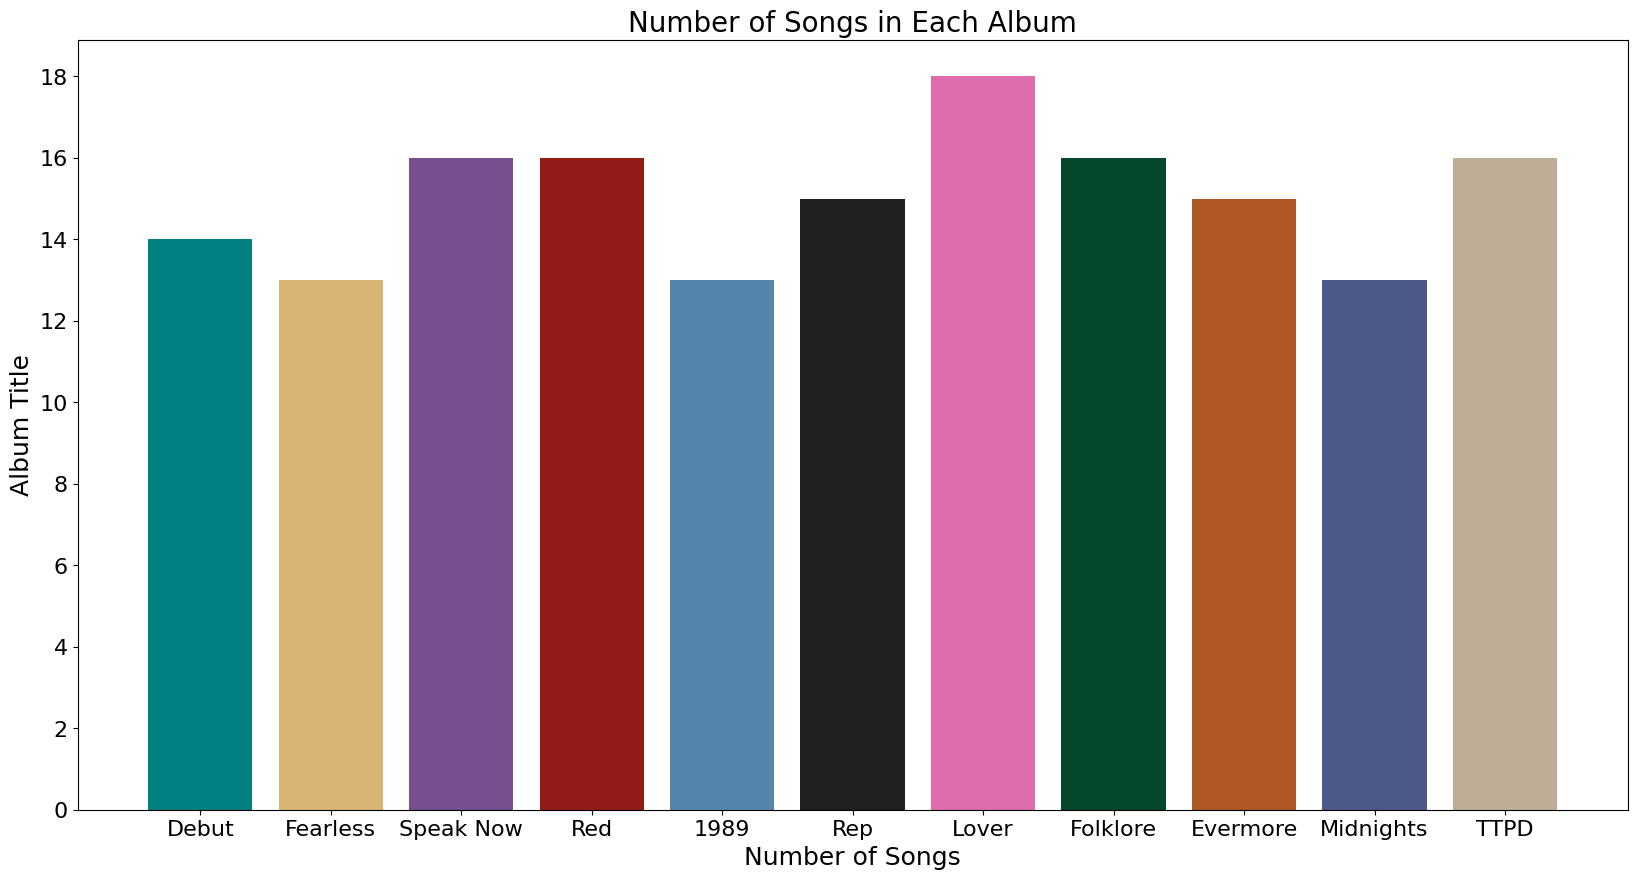

Correlation Coefficient: 0.2995237825205776
P-Value: 0.37088058568365234


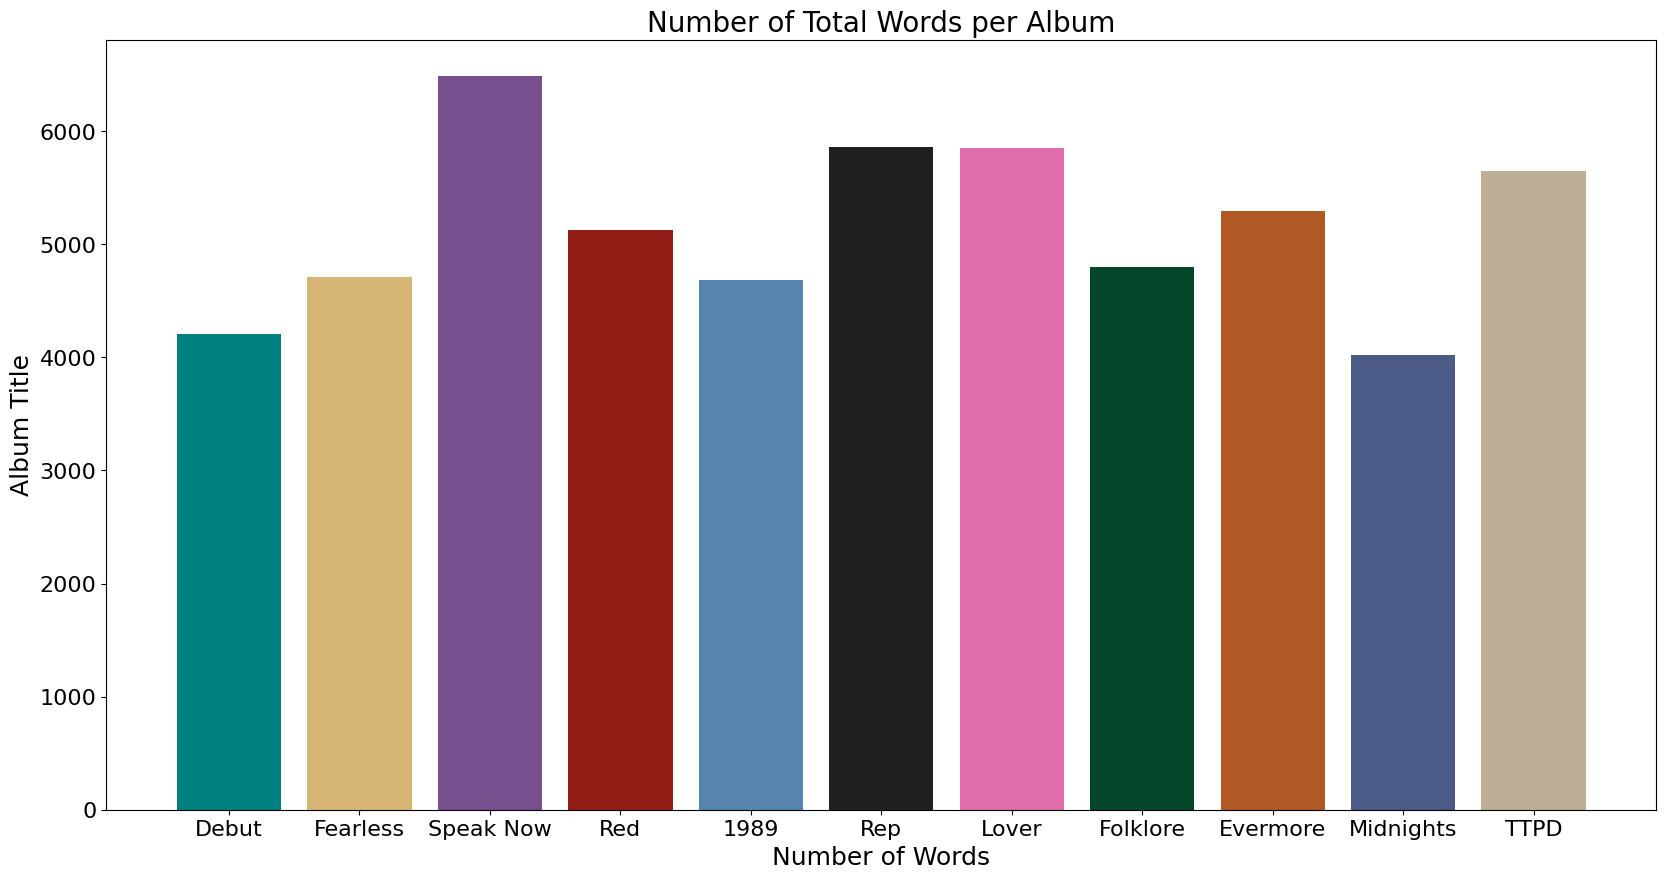

Correlation Coefficient: 0.11415818914382077
P-Value: 0.7382175225205142


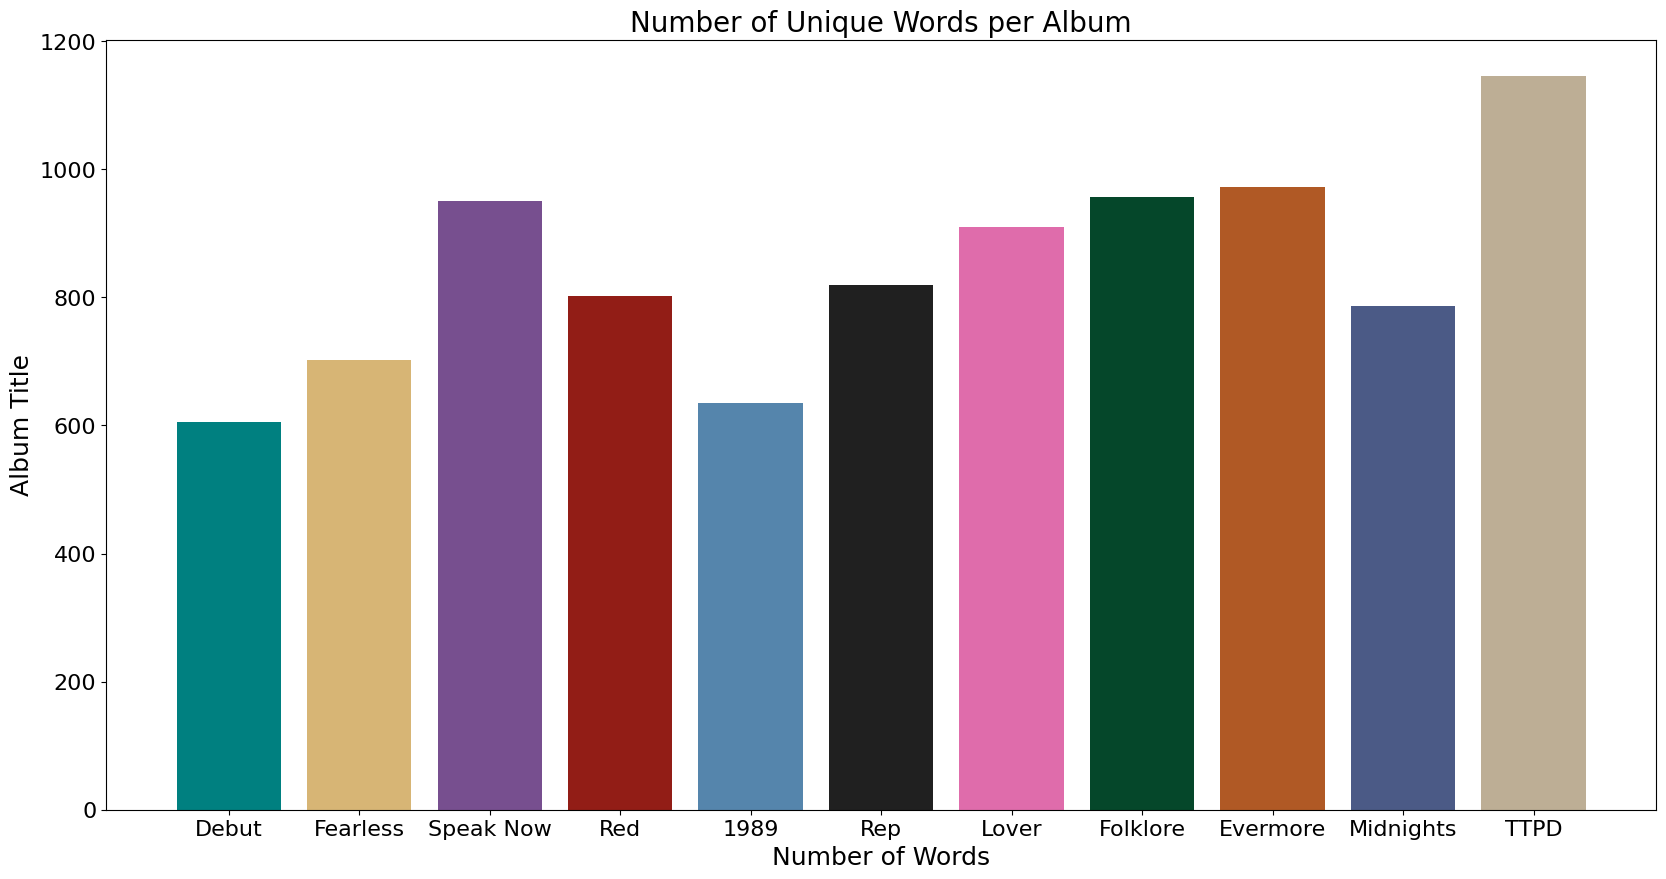

Correlation Coefficient: 0.6855979512389322
P-Value: 0.01987292213858246


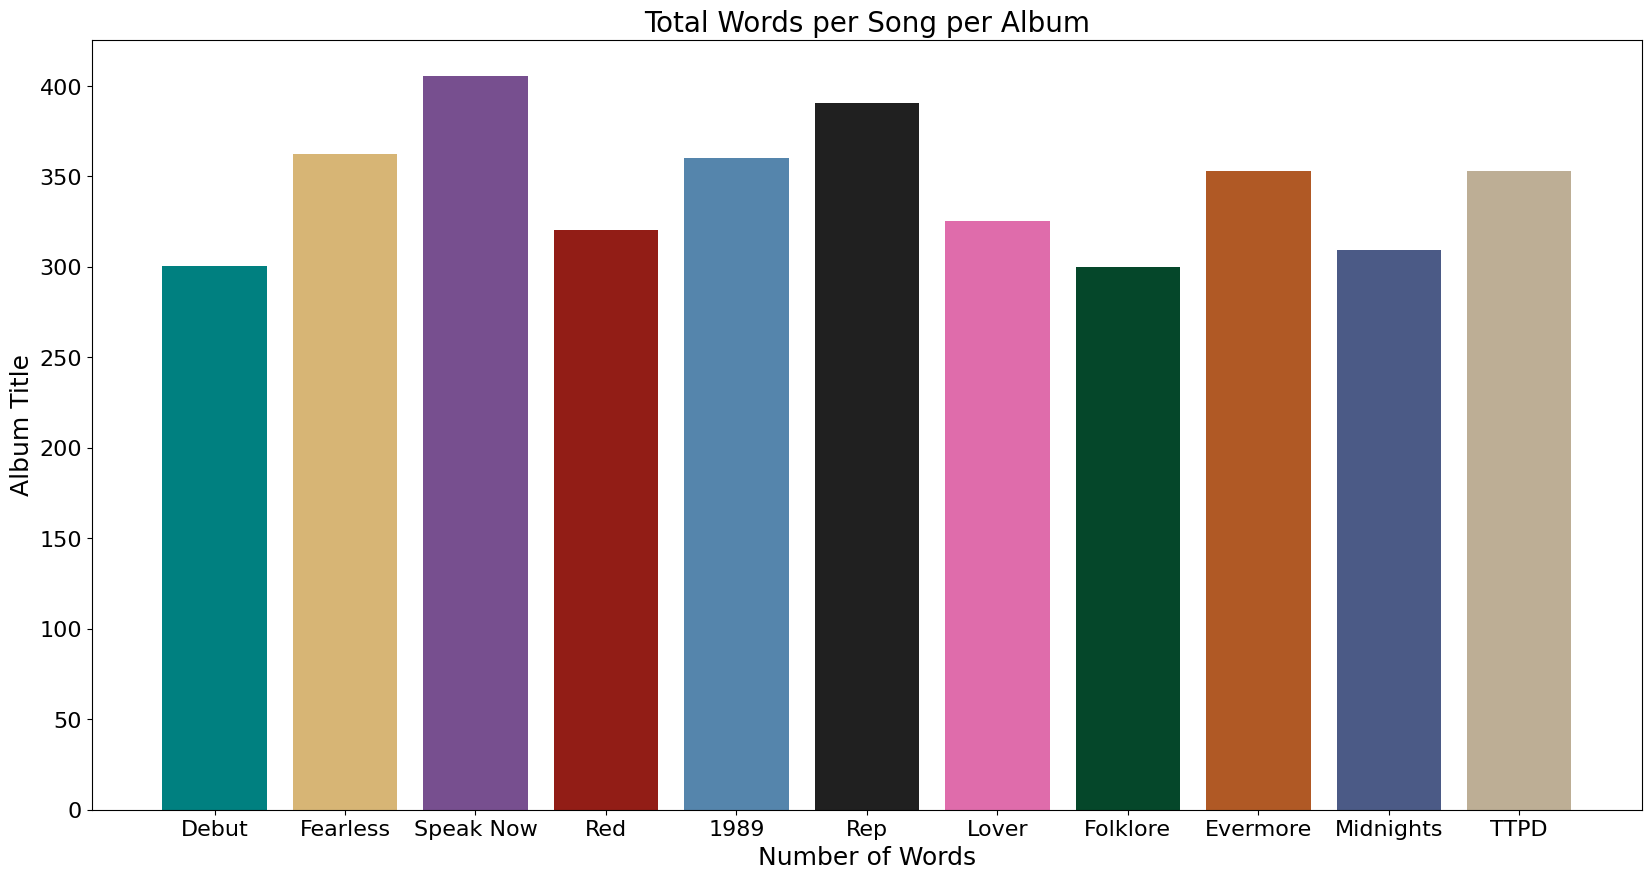

Correlation Coefficient: -0.14216086521310153
P-Value: 0.6767061483839998


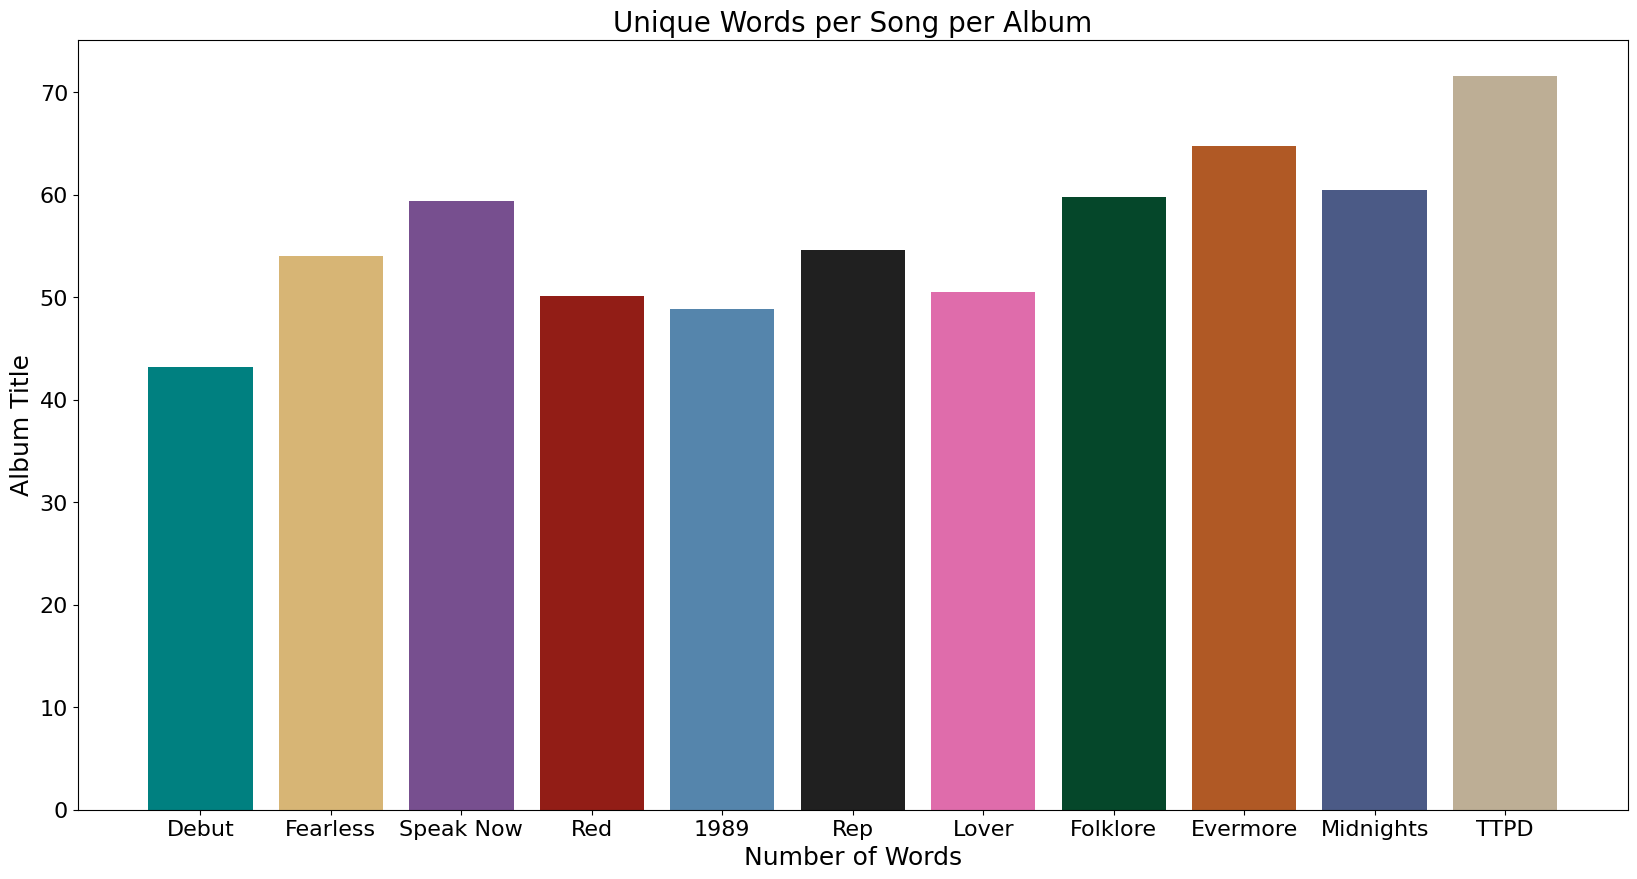

Correlation Coefficient: 0.7135149646387723
P-Value: 0.01367896859297243


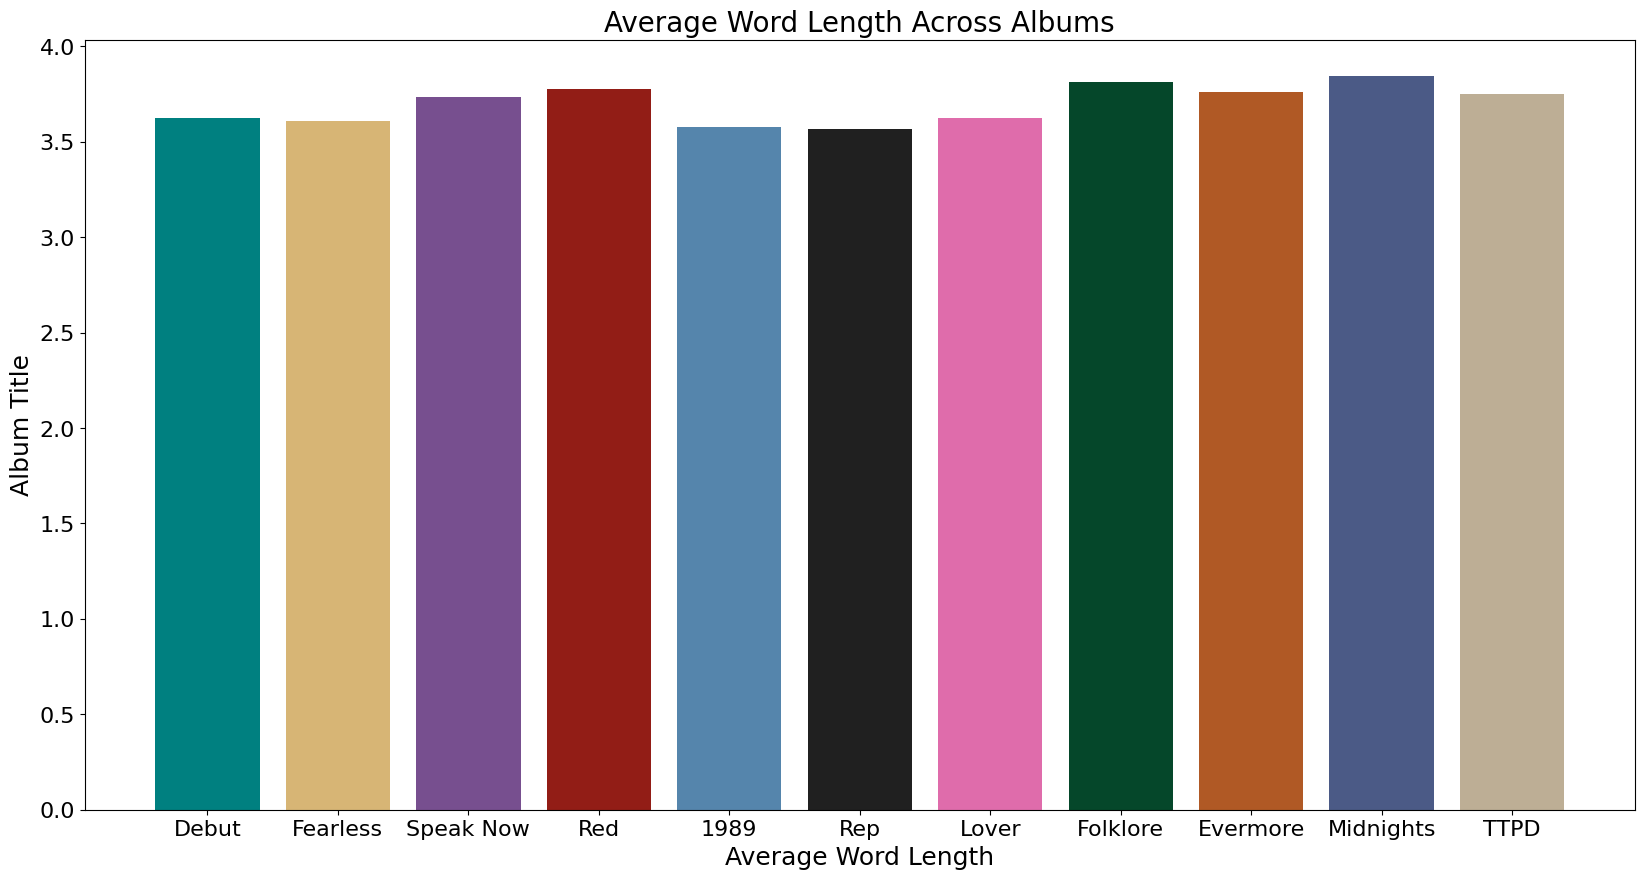

Correlation Coefficient: 0.4687194970192737
P-Value: 0.14588158401430146


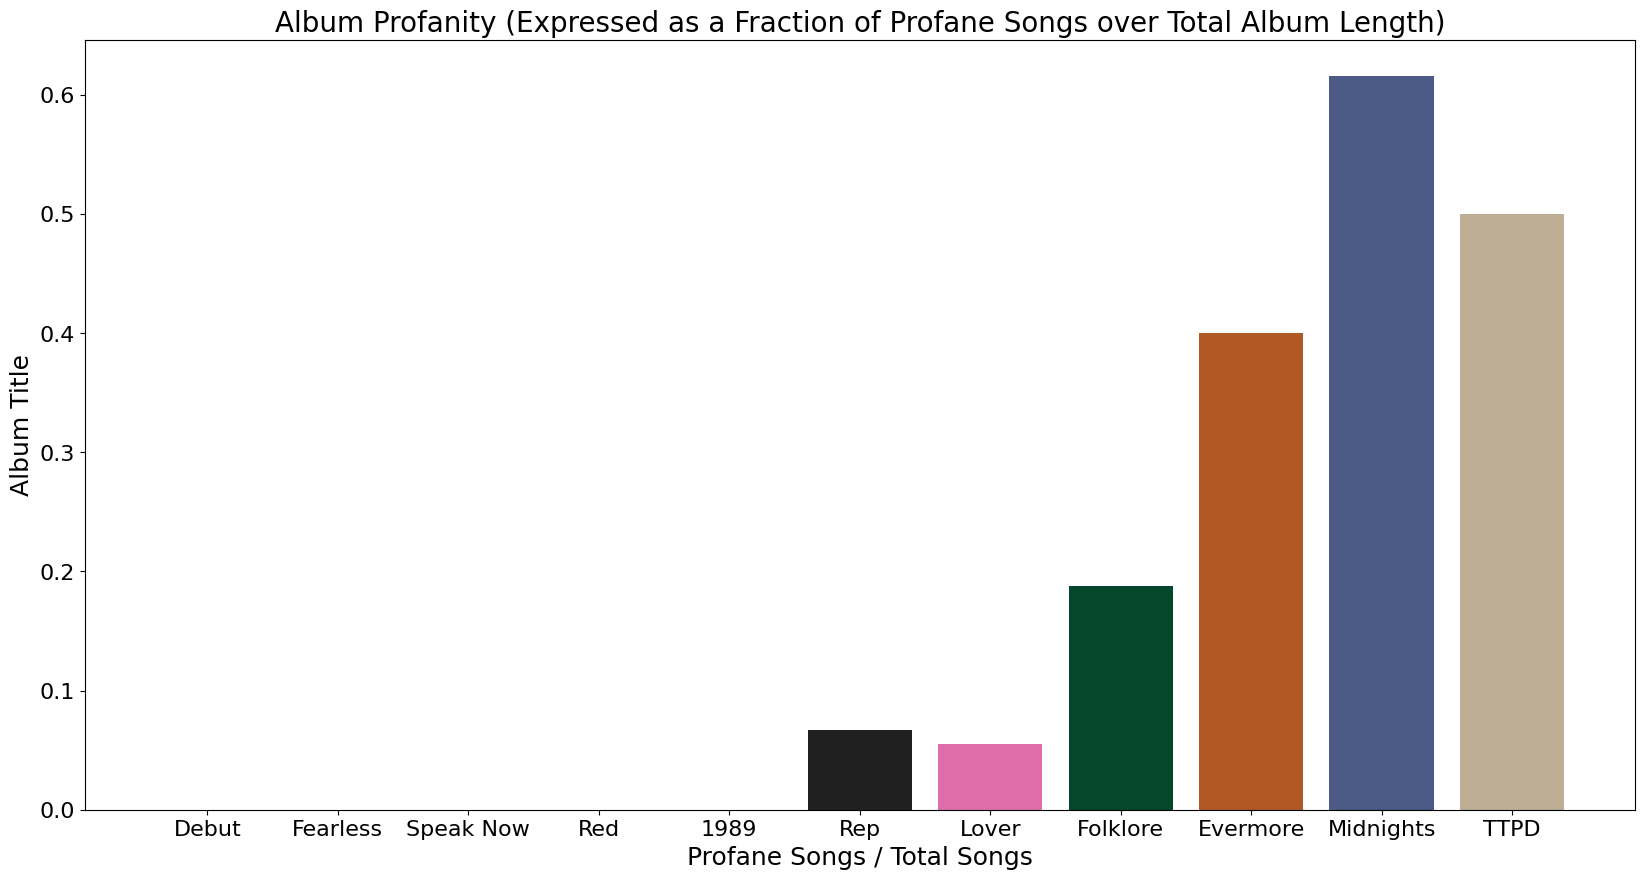

Correlation Coefficient: 0.7924295035835265
P-Value: 0.003633615130738361


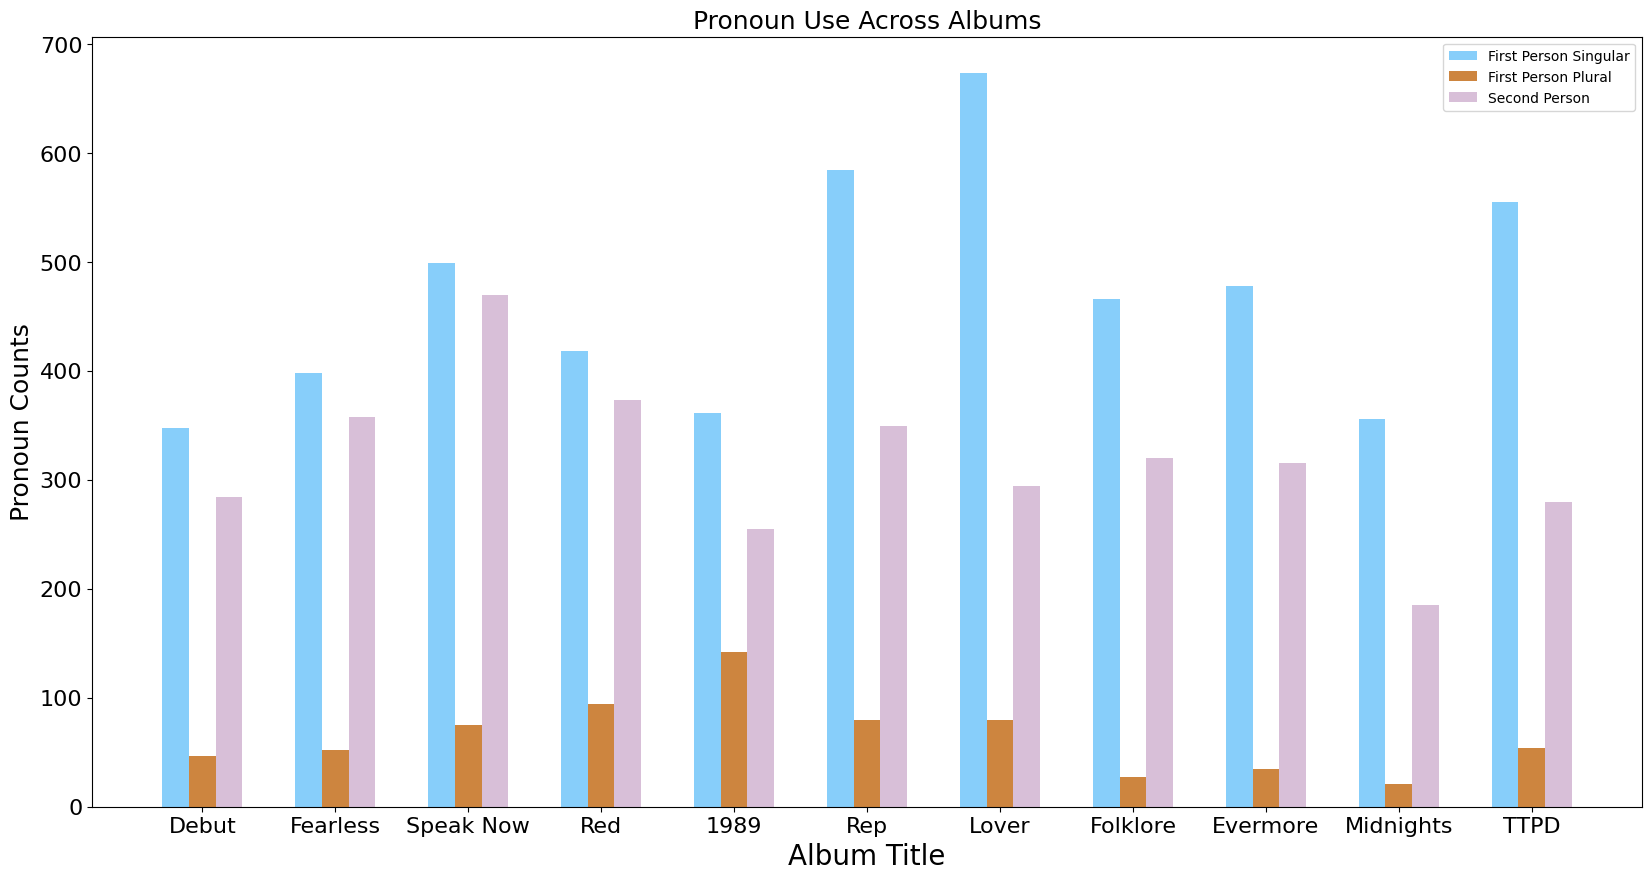

FPSP Correlation Coefficient: 0.4401601595663537
FPSP P-Value: 0.17547491504602242
FPPP Correlation Coefficient: -0.29213968478870495
FPPP P-Value: 0.3833573869485525
SPP Correlation Coefficient: -0.48682847808580454
SPP P-Value: 0.12885707279717687


In [9]:
if __name__ == "__main__":
    main()